In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess
import random

cheated_0 = Events('CheatedRecoFile_0.root')
plt.rcParams.update({'font.size': 12})

In [2]:
mc_pdg_dict = {
    -2212: "Anti proton",
    -321: "K-",
    -211: "π-",
    -13: "μ-",
    -11: "e- ",
    11: "e+",
    13: "μ+",
    22: "γ",
    211: "π+",
    321: "K+",
    2212: "proton",
    3112: "Σ-",
    3222: "Σ+",
    
    # Light Nuclei
    1000010020: "Deuteron",
    1000010030: "Triton",
    1000010040: "Helium-3",
    1000020030: "Helium-3 (alt)",
    1000020040: "Alpha Particle (He-4)",
    1000020060: "Helium-6",
    1000030060: "Lithium-6",
    1000030070: "Lithium-7",
    1000030080: "Lithium-8",
    1000040080: "Beryllium-8",
    1000040090: "Beryllium-9",
    1000040100: "Beryllium-10",
    1000070150: "Nitrogen-15",
    1000070160: "Nitrogen-16",
    1000070170: "Nitrogen-17",
    
    # Heavier Nuclei
    1000100200: "Neon-20",
    1000100220: "Neon-22",
    1000110230: "Sodium-23",
    1000120240: "Magnesium-24",
    1000120250: "Magnesium-25",
    1000120260: "Magnesium-26",
    1000120270: "Magnesium-27",
    1000120280: "Magnesium-28",
    1000130260: "Aluminum-26",
    1000130270: "Aluminum-27",
    1000130280: "Aluminum-28",
    1000130290: "Aluminum-29",
    1000140270: "Silicon-27",
    1000140280: "Silicon-28",
    1000140290: "Silicon-29",
    1000140300: "Silicon-30",
    1000140310: "Silicon-31",
    1000140320: "Silicon-32",
    1000140330: "Silicon-33",
    1000140340: "Silicon-34",
    1000150300: "Phosphorus-30",
    1000150310: "Phosphorus-31",
    1000150320: "Phosphorus-32",
    1000150330: "Phosphorus-33",
    1000150340: "Phosphorus-34",
    1000150350: "Phosphorus-35",
    1000150360: "Phosphorus-36",
    1000150370: "Phosphorus-37",
    1000160310: "Sulfur-31",
    1000160320: "Sulfur-32",
    1000160330: "Sulfur-33",
    1000160340: "Sulfur-34",
    1000160350: "Sulfur-35",
    1000160360: "Sulfur-36",
    1000160370: "Sulfur-37",
    1000160380: "Sulfur-38",
    1000160390: "Sulfur-39",
    1000170340: "Chlorine-34",
    1000170350: "Chlorine-35",
    1000170360: "Chlorine-36",
    1000170370: "Chlorine-37",
    1000170380: "Chlorine-38",
    1000170390: "Chlorine-39",
    1000170400: "Chlorine-40",
    1000180350: "Argon-35",
    1000180360: "Argon-36",
    1000180370: "Argon-37",
    1000180380: "Argon-38",
    1000180390: "Argon-39",
    1000180400: "Argon-40",
    1000180410: "Argon-41",
    1000190380: "Potassium-38",
    1000190390: "Potassium-39",
    1000190400: "Potassium-40",
    1000190410: "Potassium-41",
}

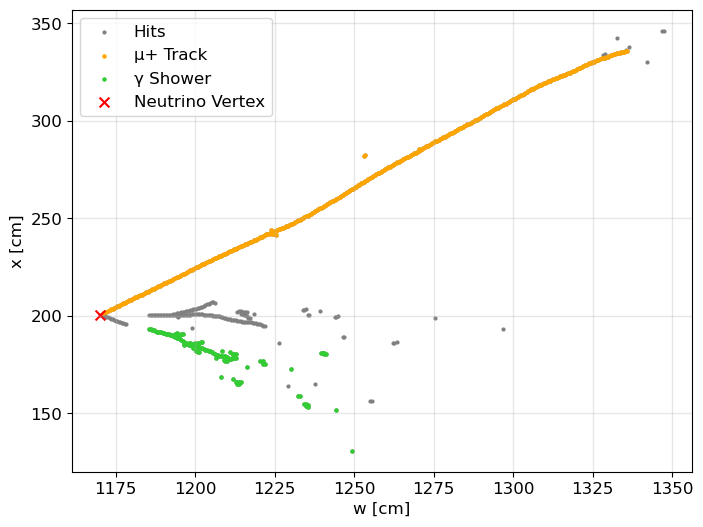

In [3]:
def plot_event(events, event_number):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]

    if event_indices.size < 3:
        return
    w_hits = np.concatenate(events.reco_hits_w[event_indices])
    x_hits = np.concatenate(events.reco_hits_x_w[event_indices])

    w_track = events.reco_hits_w[event_indices[1]]
    x_track = events.reco_hits_x_w[event_indices[1]]

    w_shower = events.reco_hits_w[event_indices[10]]
    x_shower = events.reco_hits_x_w[event_indices[10]]

    pdg_track = events.mc_pdg[event_indices[1]]
    pdg_shower = events.mc_pdg[event_indices[10]]

    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = (8,6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.scatter(w_hits, x_hits, s=4, c='grey', label='Hits')
    plt.scatter(w_track, x_track, s=5, c='orange', label=f'{mc_pdg_dict[pdg_track]} Track')
    plt.scatter(w_shower, x_shower, s=5, c='limegreen', label=f'{mc_pdg_dict[pdg_shower]} Shower')
    plt.scatter(events.neutrino_vtx_w[event_indices[0]], events.neutrino_vtx_x[event_indices[0]], marker='x', s=50, c='#F00', label='Neutrino Vertex')
    plt.xlabel('w [cm]')
    plt.ylabel('x [cm]')
    plt.legend()
    plt.show()

plot_event(cheated_0, 65)

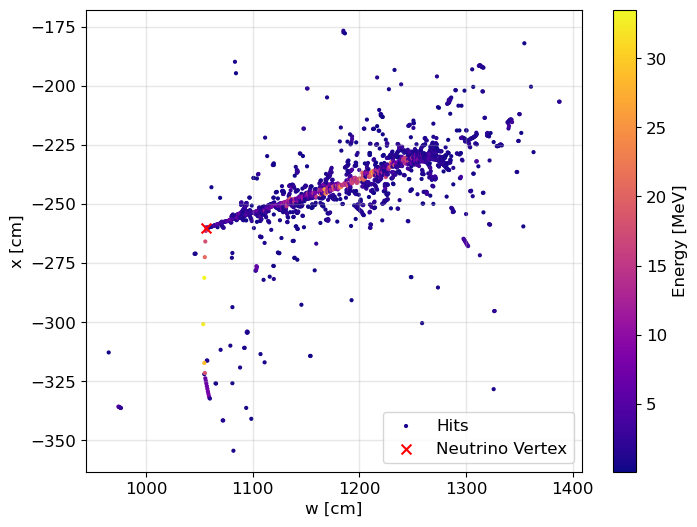

In [4]:
def plot_event_adc(events, event_number):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]
    adcs = np.concatenate(events.reco_adcs_w[event_indices])
    adcs = 0.0075 * adcs

    if event_indices.size < 3:
        return
    w_hits = np.concatenate(events.reco_hits_w[event_indices])
    x_hits = np.concatenate(events.reco_hits_x_w[event_indices])

    norm = plt.Normalize(vmin=np.min(adcs), vmax=np.max(adcs))
    cmap = plt.get_cmap('plasma')
    
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = (8,6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    scatter = plt.scatter(w_hits, x_hits, s=4, c=adcs, cmap=cmap, label='Hits', norm=norm)
    plt.scatter(events.neutrino_vtx_w[event_indices[0]], events.neutrino_vtx_x[event_indices[0]], marker='x', s=50, c='#F00', label='Neutrino Vertex')
    plt.xlabel('w [cm]')
    plt.ylabel('x [cm]')
    plt.colorbar(scatter, label='Energy [MeV]')
    plt.legend()
    plt.show()

plot_event_adc(cheated_0, 1427)

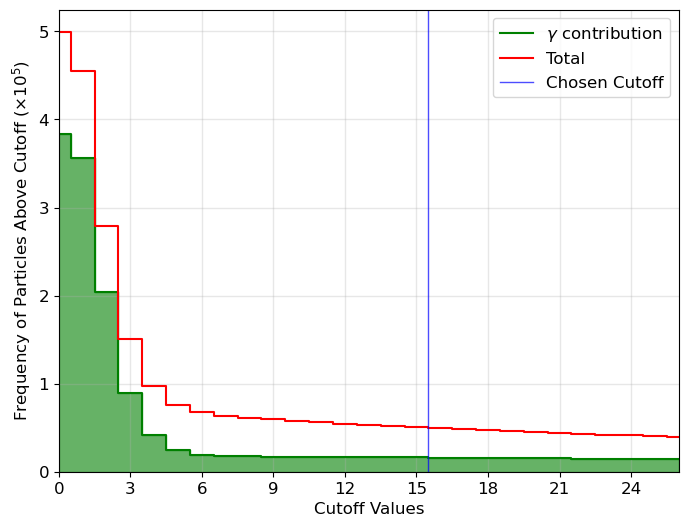

In [6]:
""" Study on length of hits in an event """

def length_over_cutoff(events):
    allhits = events.reco_hits_w
    len_arr = np.array([len(hits) for hits in allhits])

    pdgs = events.mc_pdg
    gamma_mask = np.array([22 in np.atleast_1d(a) for a in pdgs])
    gamma_len_arr = len_arr[gamma_mask]
    
    numbers = np.arange(27)

    tallyarr = []
    gammas = []
    
    for i in range(27):
        test_arr = len_arr[len_arr >= i]
        gamma_test = gamma_len_arr[gamma_len_arr >= i]
        tallyarr.append(len(test_arr))
        gammas.append(len(gamma_test))

    tallyarr = np.array(tallyarr)
    gammas = np.array(gammas)

    plt.figure(figsize=(8,6))
    plt.step(numbers, gammas/100000, where='mid', c='g', linewidth=1.5, label=r'$\gamma$ contribution')
    plt.step(numbers, tallyarr/100000, where='mid', c='r', linewidth=1.5, label='Total')
    plt.fill_between(numbers, 0, gammas/100000, step='mid', color='g', alpha=0.6)
    plt.axvline(15.5, c='blue', linestyle='-', linewidth=1, alpha=0.7, label='Chosen Cutoff')
    plt.xlabel('Cutoff Values')
    plt.ylabel(r'Frequency of Particles Above Cutoff $(\times 10^5)$')
    plt.xticks(np.arange(0, 27, 3))
    plt.ylim(bottom=0)
    plt.xlim(0,26)
    plt.legend()
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.show()

length_over_cutoff(cheated_0)

In [6]:
def bragg_demo(events, event_idx):
    w_hits = events.reco_hits_w[event_idx] - events.reco_particle_vtx_w[event_idx]
    adcs = events.reco_adcs_w[event_idx] * 0.0075

    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.scatter(w_hits, adcs, s=12, c='darkorange', alpha=0.6, label='Energy Deposition')
    plt.xlabel('r [cm]')
    plt.ylabel('Energy [MeV]')
    plt.show()

for k in range(5000):
    if len(cheated_0.reco_hits_w[k]) > 600 and cheated_0.mc_pdg[k] not in [-11, 11, 22]:
        print(k)

165
260
819
957
1097
1554
1562
2181
2191
2213
2233
2803
2932
3179
3287
3531
3788
3885
3888
3949
3983
4061
4108
4566
4674
4686
4815
4870


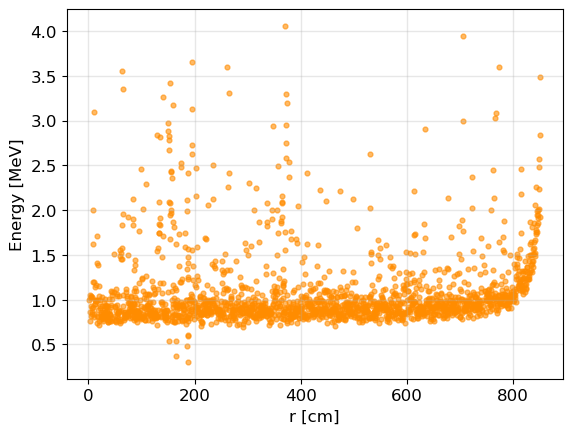

In [7]:
bragg_demo(cheated_0, 1097)

e: 207491, mu: 110751


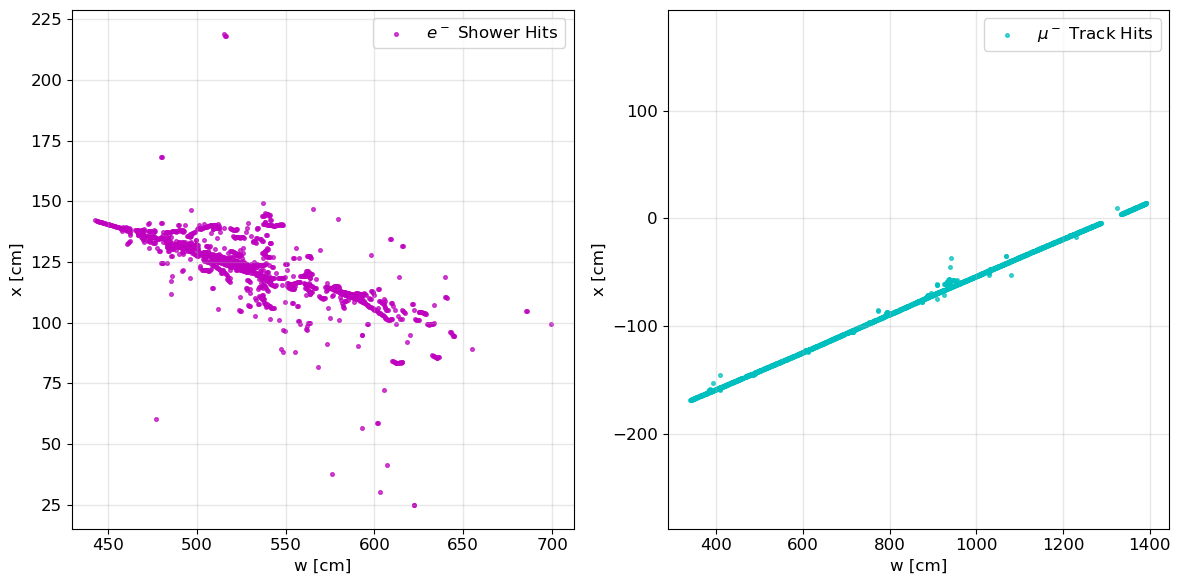

In [124]:
def plot_Tr_Sh(events):
    hits_sizes = np.array([len(w) for w in events.reco_hits_w])
    pdgs = events.mc_pdg
    indices = np.arange(len(pdgs))

    # Electron mask for pdg in [-11, 11] and hits size > 1000
    e_mask = (np.isin(pdgs, [-11, 11])) & (hits_sizes > 1000)
    e_idx = np.random.choice(indices[e_mask])  # Randomly select one satisfying condition
    
    # Muon mask for pdg in [-13, 13] and hits size > 1000
    mu_mask = (np.isin(pdgs, [-13, 13])) & (hits_sizes > 1000)
    mu_idx = np.random.choice(indices[mu_mask])  # Randomly select one satisfying condition

    e_idx = 207491
    mu_idx = 110751
    print(f'e: {e_idx}, mu: {mu_idx}')

    w_e = events.reco_hits_w[e_idx]
    x_e = events.reco_hits_x_w[e_idx]

    w_mu = events.reco_hits_w[mu_idx]
    x_mu = events.reco_hits_x_w[mu_idx]

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Electron Shower
    axs[0].grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    axs[0].scatter(w_e, x_e, s=7, color='m', alpha=0.7, label=r'$e^-$ Shower Hits')
    axs[0].set_xlabel('w [cm]')
    axs[0].set_ylabel('x [cm]')
    axs[0].legend()
    
    # Muon Track
    axs[1].grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    axs[1].scatter(w_mu, x_mu, s=7, color='c', alpha=0.7, label=r'$\mu^-$ Track Hits')
    axs[1].set_xlabel('w [cm]')
    axs[1].set_ylabel('x [cm]')
    axs[1].legend()

    lower_limit1, upper_limit1 = axs[1].get_ylim()
    new_lower_limit1 = lower_limit1 - 110
    new_upper_limit1 = upper_limit1 + 170
    
    # Set the new y-limits for axs[1]
    axs[1].set_ylim(new_lower_limit1, new_upper_limit1)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

plot_Tr_Sh(cheated_0)

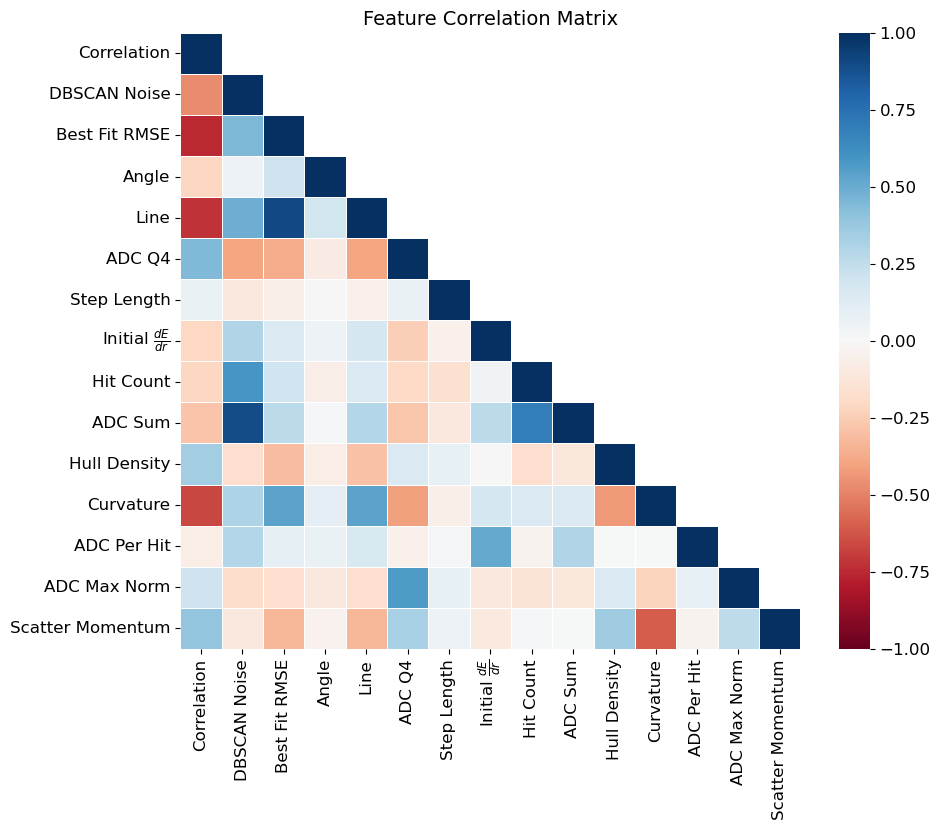

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})
data = np.load("15f_training.npz", allow_pickle=True)["x_train"]

# Create a DataFrame with feature names
feature_names = [
    'Correlation', 'DBSCAN Noise', 'Best Fit RMSE', 'Angle', 'Line',
    'ADC Q4', 'Step Length', r'$\text{Initial } \frac{dE}{dr}$', 'Hit Count',
    'ADC Sum', 'Hull Density', 'Curvature', 'ADC Per Hit', 'ADC Max Norm', 'Scatter Momentum'
]

df = pd.DataFrame(data, columns=feature_names)

# Compute correlation matrix
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Plot the heatmap with the RdBu colormap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="RdBu", center=0, linewidths=0.5, vmin=-1, vmax=1)

# Set title
plt.title("Feature Correlation Matrix", fontsize=14)

# Show the plot
plt.show()


In [63]:
abs_corr = corr_matrix.abs()

mean_corr = abs_corr.apply(lambda x: x.drop(x.name).mean(), axis=1)
print(mean_corr)

Correlation                        0.360922
DBSCAN Noise                       0.343596
Best Fit RMSE                      0.343443
Angle                              0.090458
Line                               0.346009
ADC Q4                             0.284431
Step Length                        0.069868
$\text{Initial } \frac{dE}{dr}$    0.171774
Hit Count                          0.200263
ADC Sum                            0.270095
Hull Density                       0.189240
Curvature                          0.311187
ADC Per Hit                        0.123986
ADC Max Norm                       0.181405
Scatter Momentum                   0.211898
dtype: float64


/tmp/ipykernel_293/4260130888.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_corr.values, y=mean_corr.index, linewidth=1, edgecolor="black", palette=colors)


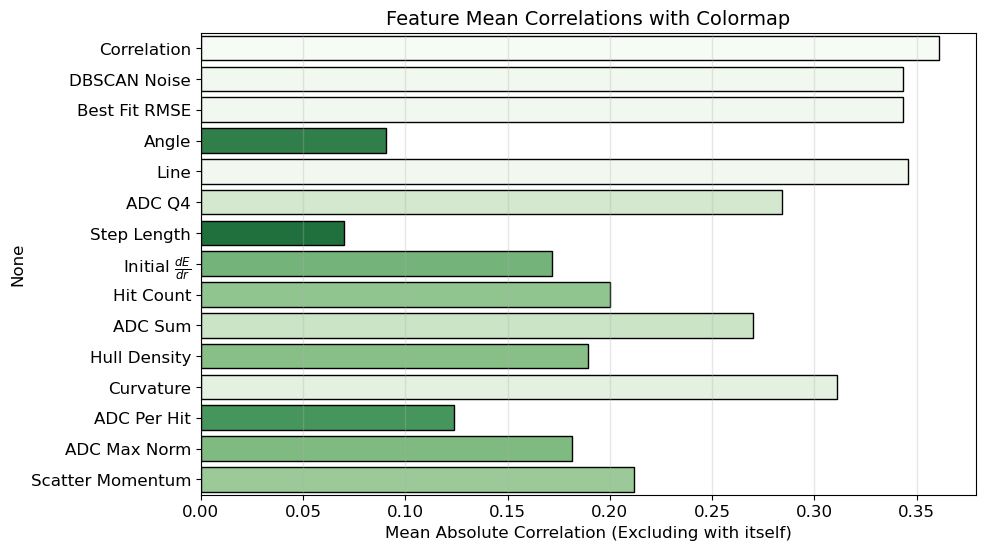

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# Normalize the mean correlation values to map them to the colormap
norm = mcolors.Normalize(vmin=0, vmax=mean_corr.max())
cmap = plt.get_cmap("Greens_r")  # You can choose any colormap here

# Create a color array based on the normalized values and colormap
colors = [cmap(norm(val)) for val in mean_corr.values]

# Set figure size
plt.figure(figsize=(10, 6))

# Create bar plot with colormap applied
plt.grid(visible=True, which='major', axis='x', linestyle='-', linewidth=1.0, alpha=0.3)
sns.barplot(x=mean_corr.values, y=mean_corr.index, linewidth=1, edgecolor="black", palette=colors)

# Add labels
plt.xlabel("Mean Absolute Correlation (Excluding with itself)", fontsize=12)
plt.title("Feature Mean Correlations with Colormap", fontsize=14)

# Show plot
plt.show()

In [ ]:
"""
'dwanbui' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 
'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 
'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r',
'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu',
'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r',
'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn',
'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn',
'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r',
'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r',
'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey',
'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern',
'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray',
'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r',
'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r',
'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r',
'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c',
'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted',
'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
"""

In [2]:
def step_length(events, event_idx, min_hits=15):
    # Find all info for the feature
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]

    # Skip events where there are fewer than 15 hits
    if len(w_hits) <= min_hits:
        return None  # Return None to indicate that the feature should be skipped

    # Finding step length
    w_step = min([abs(w - w_vtx) for w in w_hits])
    x_step = min([abs(x - x_vtx) for x in x_hits])
    step_length = np.sqrt(w_step**2 + x_step**2)

    return step_length

In [12]:
gamma_idx = []
e_idx = []

for i in range(len(cheated_0.event_number)):
    if len(cheated_0.reco_hits_w[i]) > 1000:
        if cheated_0.mc_pdg[i] == 22:
            gamma_idx.append(i)
        elif cheated_0.mc_pdg[i] in [-11, 11]:
            e_idx.append(i)

print(gamma_idx)

[4114, 6419, 7178, 17089, 27157, 35472, 53752, 57254, 63206, 69919, 99585, 115643, 121023, 121569, 158397, 165478, 211840, 214082, 222584, 225291, 240878, 258332, 265241, 273862, 280817, 287763, 321216, 322007, 329794, 331196, 335524, 340295, 361346, 366622, 392835, 396960, 418411, 431355, 435410, 449059, 453272, 480041, 480907, 482880]


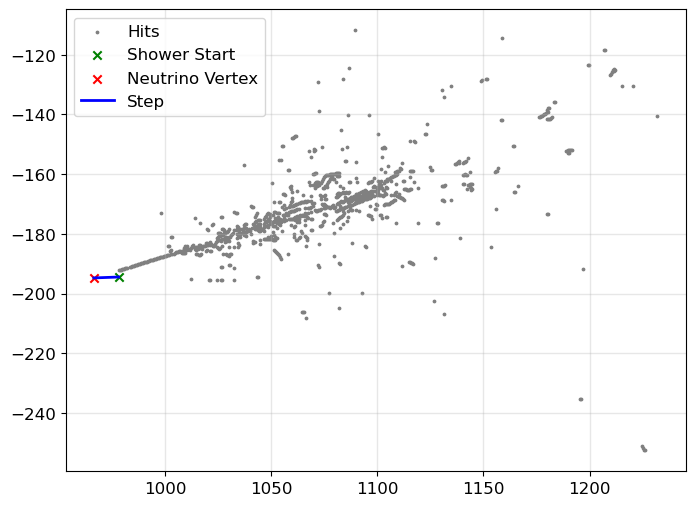

In [22]:
plt.rcParams.update({'font.size': 12})
def step_length_plot(events, event_idx, min_hits=15):
    # Find all info for the feature
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]

    # Skip events where there are fewer than 15 hits
    if len(w_hits) <= min_hits:
        return None  # Return None to indicate that the feature should be skipped

    # Finding step length
    w_idx = np.argmin([abs(w - w_vtx) for w in w_hits])
    x_idx = np.argmin([abs(x - x_vtx) for x in x_hits])

    start_w = w_hits[w_idx]
    start_x = x_hits[x_idx]

    plt.figure(figsize=(8,6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.scatter(w_hits, x_hits, c='gray', s=3, label='Hits')
    plt.scatter(start_w, start_x, c='g', marker='x', label='Shower Start')
    plt.scatter(w_vtx, x_vtx, c='r', marker='x', label='Neutrino Vertex')
    plt.plot([w_vtx, start_w], [x_vtx, start_x], c='b', linewidth=2, label='Step')
    plt.legend()
    plt.show

step_length_plot(cheated_0, gamma_idx[3])